In [1]:
import os
import yaml
import torch
import gdown
import shutil
import zipfile
from PIL import Image
from pathlib import Path
from google.colab import files
from xml.etree import ElementTree
from sklearn.model_selection import train_test_split

# Instalación de Yolo

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-207-g5774a15 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/78.2 GB disk)


# Extracción del DataSet

Descarga

In [3]:
zip_file_url = 'https://drive.google.com/uc?id=1CFeq6JVz5coNzvoIVfzh0vmnh7l-VSUl'
zip_file_name = gdown.download(zip_file_url, quiet=True)

In [4]:
zip_folder_name = Path(zip_file_name).stem

TRAIN_IMAGES_FOLDER = f'{zip_folder_name}/images/train/'
TRAIN_LABELS_FOLDER = f'{zip_folder_name}/labels/train/'
TEST_IMAGES_FOLDER = f'{zip_folder_name}/images/test/'
TEST_LABELS_FOLDER = f'{zip_folder_name}/labels/test/'

In [5]:
zip_file_manager = zipfile.ZipFile(zip_file_name, 'r')

Se recuperan los nombres únicos de los archivos sin extensión.

In [6]:
file_names = list(set([Path(i).stem for i in zip_file_manager.namelist()])) 

Separación en train y test.

In [7]:
train, test = train_test_split(file_names, test_size=0.3, random_state=42)

Se descomprimen las imágenes y sus etiquetan en la carpeta correspondiente según la asignación obtenida por la instrucción anterior.

In [8]:
for folder, data in zip((TRAIN_IMAGES_FOLDER, TEST_IMAGES_FOLDER), (train, test)):
  for file_name in data:
    zip_file_manager.extract(f'{file_name}.jpg', f'./{folder}')

for folder, data in zip((TRAIN_LABELS_FOLDER, TEST_LABELS_FOLDER), (train, test)):
  for file_name in data:
    zip_file_manager.extract(f'{file_name}.xml', f'./{folder}')

# Parametrización del problema (archivo yaml)

Se crea el archivo que parametriza el origen de los datos y las categorías etiquetadas.

In [9]:
# creamos yaml
yaml_dict = {'train': TRAIN_IMAGES_FOLDER,
             'val': TEST_IMAGES_FOLDER,
             'nc': 1,
             'names': ['pothole']}

with open('/content/yolov5/data/pothole.yaml', 'wt') as f:
  data = yaml.dump(yaml_dict, f, default_flow_style=False)

# Conversión de etiquetas a formato Yolo

In [10]:
def convert_to_yolov5(info_dict, class_name_to_id_mapping):
    print_buffer = []

    # Para cada bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("File is: ", info_dict['filename'])
            print("Class is: ", b["class"])
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
            continue

        # Transformamos las coordenadas de la bbox para yolo
        b_center_x = (b["xmin"] + b["xmax"]) / 2.0 -1
        b_center_y = (b["ymin"] + b["ymax"]) / 2.0 -1
        b_width = (b["xmax"] - b["xmin"])
        b_height = (b["ymax"] - b["ymin"])

        # Normalizamos las coordenadas usando la dimension de la imagen
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width /= image_w
        b_height /= image_h

        # guardamos la info
        print_buffer.append(
            "{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    return print_buffer

In [11]:
def extract_info_from_xml(xml_file):
    root = ElementTree.parse(xml_file).getroot()

    # inicializamos el dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parseamos el XML Tree
    for elem in root:
        # obtenemos el nombre de archivo
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # tamaño de imagen
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

Cada archivo .xml es convertido al formato yolo y eliminado.

In [12]:
class_name_to_id_mapping = {'pothole': 0}

for folder in (TRAIN_LABELS_FOLDER, TEST_LABELS_FOLDER):
  xml_files = os.listdir(folder)
  for xml_file in xml_files:
    full_xml_path = f'{folder}{xml_file}'
    full_txt_path = f'{folder}{Path(xml_file).stem}.txt'

    info_dict = extract_info_from_xml(full_xml_path)
    print_buffer = convert_to_yolov5(info_dict, class_name_to_id_mapping)
    with open(full_txt_path, 'w') as f:
      print("\n".join(print_buffer), file=f)
    
    os.remove(full_xml_path)

# Entrenamiento

## Sin *image augmentation* hiperparámetros

Se crea un nuevo archivo con los hiperparámetros del modelo, copiando el propuesto por la herramienta y anulando opciones de *image augmentation*.

In [13]:
with open('/content/yolov5/data/hyps/hyp.scratch-low.yaml', 'rt') as f:
  next(f) # en la primera línea hay un caracter especial: 🚀
  hyperparameters = yaml.safe_load(f)

hyperparameters['degrees'] = 0.0
hyperparameters['translate'] = 0.0
hyperparameters['scale'] = 0.0
hyperparameters['shear'] = 0.0
hyperparameters['perspective'] = 0.0
hyperparameters['flipud'] = 0.0
hyperparameters['fliplr'] = 0.0
hyperparameters['mosaic'] = 0.0
hyperparameters['mixup'] = 0.0
hyperparameters['copy_paste'] = 0.0

with open('/content/yolov5/data/hyps/custom_hyp.scratch-low.yaml', 'w') as f:
  yaml.dump(hyperparameters, f, default_flow_style=False)

Entrenamiento sin *image augmentation*

In [15]:
!python train.py --img 800 --batch 32 --epochs 30 --data ./data/pothole.yaml --weights yolov5s.pt --hyp custom_hyp.scratch-low.yaml

train: weights=yolov5s.pt, cfg=, data=./data/pothole.yaml, hyp=custom_hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=800, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-207-g5774a15 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: anchor_t=4.0, box=0.05, cls=0.5, cls_pw=1.0, copy_paste=0.0, degrees=0.0, fl_gamma=0.0, fliplr=0.0, flipud=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, iou_t=0.2, lr0=0.01, lrf=0.01, mixup=0.0, momentum=0.937, mosaic=0.0, obj=1.0, obj_pw=1.0, perspect

## Resultados

La imagen presenta las métricas de rendimiento del modelo para los conjuntos de entrenamiento y validación.

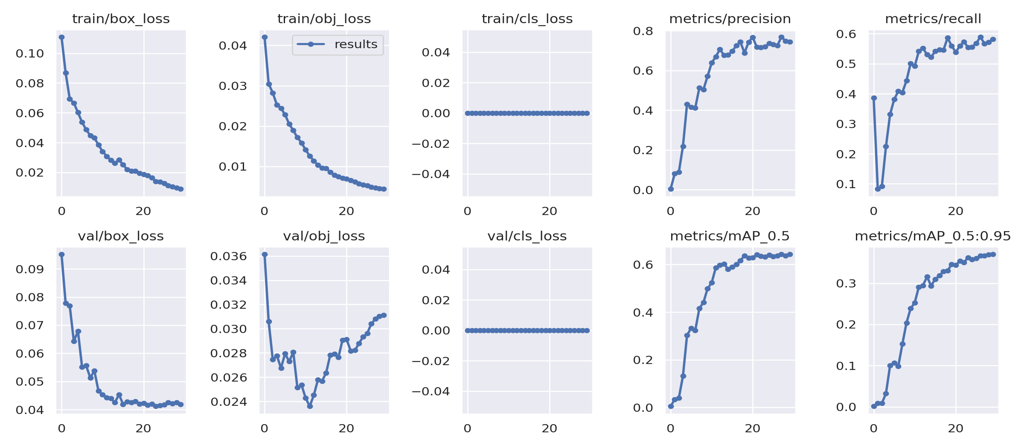

In [16]:
Image.open('/content/yolov5/runs/train/exp/results.png').resize((1024, 448))

Curva PR.

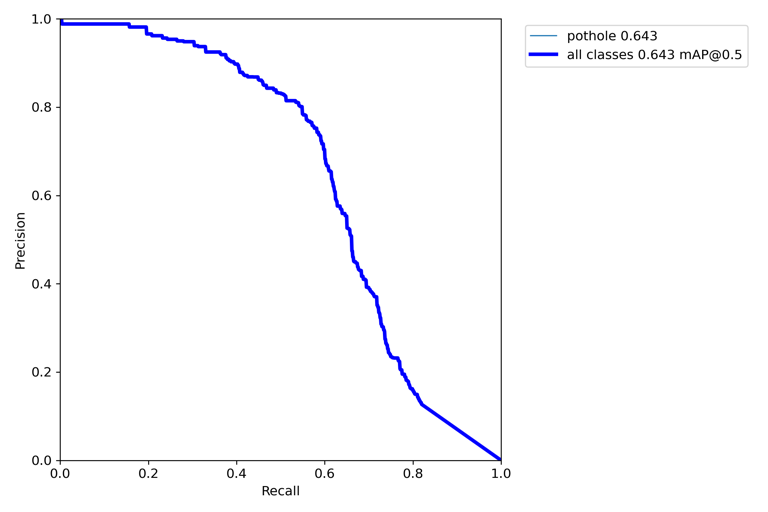

In [26]:
Image.open('/content/yolov5/runs/train/exp/PR_curve.png').resize((512+256, 512))

## Hiperparámetros por defecto (con *image augmentation*)

Se repite el entrenamiento pero con los hiperparámetro establecidos por defecto.

In [17]:
!python train.py --img 800 --batch 32 --epochs 30 --data ./data/pothole.yaml --weights yolov5s.pt --hyp hyp.scratch-low.yaml

train: weights=yolov5s.pt, cfg=, data=./data/pothole.yaml, hyp=hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=800, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-207-g5774a15 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.

## Resultados

La imagen presenta las métricas de rendimiento del modelo para los conjuntos de entrenamiento y validación.

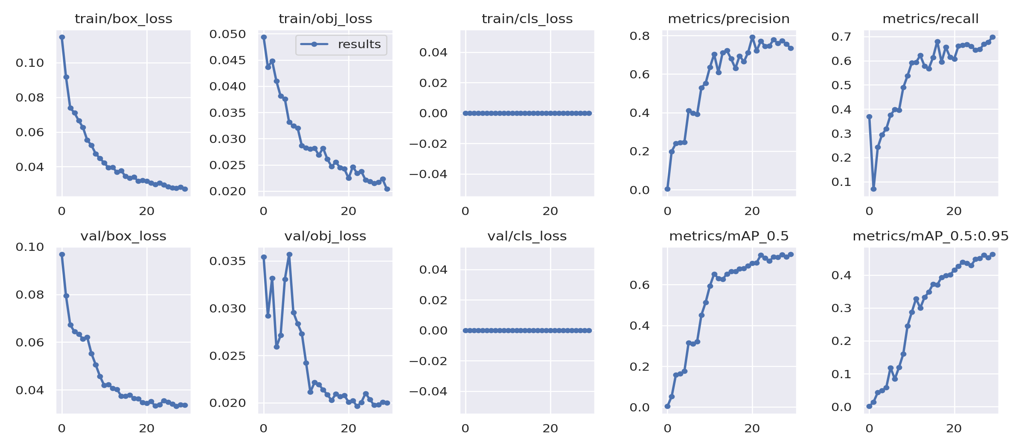

In [18]:
Image.open('/content/yolov5/runs/train/exp2/results.png').resize((1024, 448))

Curva PR.

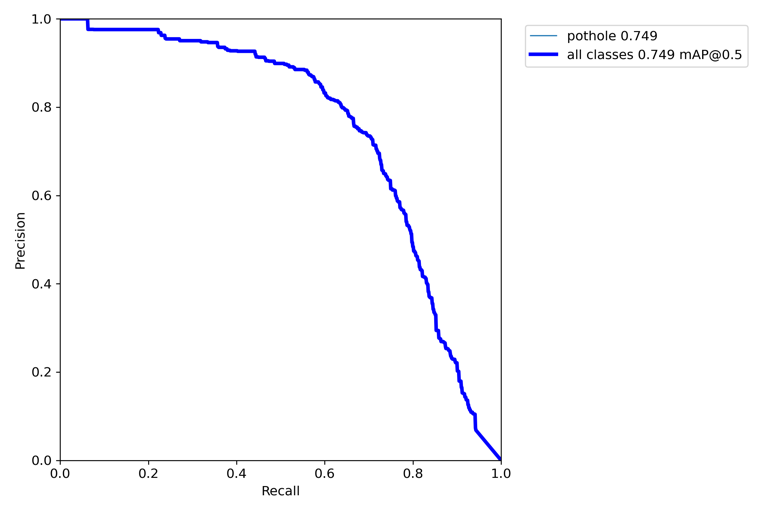

In [25]:
Image.open('/content/yolov5/runs/train/exp2/PR_curve.png').resize((512+256, 512))

# Conclusiones

La no presencia de un objeto (obj_loss) dentro de los cuadros propuestos evidencia **sobreajuste** en el primer modelo.

Dado que solo existe una clase, no hay malas identificaciones, por lo tanto el error de clasificación es constantemente cero en ambos modelos.

El **mAP_0.5** (media de la precisión promedio para el IoU o *Intersection over Union* considenrado 0.5 como *threshold*) presenta mejor evolución en el segundo modelo. La curva PR confirma la interpretación.

Por lo dicho, la sintetización de nuevos ejemplos (a partir de los existentes) controlada por los hiperparámetros del modelo, resulta en una mejor capacidad de generalización en la identificación de baches.



# Descarga

Descarga del resultado de ambos experimentos

In [19]:
runs_zip_file_name = shutil.make_archive('runs', 'zip', '/content/yolov5/runs')
files.download(runs_zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Carpeta runs](https://drive.google.com/file/d/1dcR8qzsLyi922ZN4ccfutcDtWHfdR-Rn/view?usp=sharing)